In [14]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt

In [15]:
path = '/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_0.0/light_emission/output/'
#file1 = "NSB_3MHz_test_10000.simtel.gz"
file1 = "NSB_5MHz_test_Gain_11_pxt_15_10000.simtel.gz"
file2_shifted = 'NSB_5MHz_test_Gain_20_10000.simtel.gz'
file_100k = 'ff-1m_nsb_5MHz_pxt_0_100k_event.simtel.gz'
file_nsb = 'corsika_nsb_10MHz_ampli_100_pxt_0_no_noise_100k_events.simtel.gz'



#file = 'ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz'
#file_2 = 'ff-1m_r_1nphot_2000000_dist_500_radius_150_event_test.simtel.gz'
#file_3 = 'test_10000.simtel.gz'
#file_4 = 'ff-1m_r_2nphot_6000000_dist_500_test.simtel.gz'
#file_5 = 'ff-1m_r_1nphot_2000000_dist_500_test.simtel.gz'
#file_5MHz_14Gain = 'NSB_5MHz_test_Gain_14_10000.simtel.gz'
#file_5MHz_11Gain_Pxt15 = 'NSB_5MHz_test_Gain_11_pxt_15_10000.simtel.gz'
#file_no_el_noise = 'NSB_5MHz_test_Gain_16_pxt_35_no_electronicnoise_10000.simtel.gz'

#file_no_xt = 'NSB_5MHz_test_Gain_10_pxt_0_no_electronicnoise_10000.simtel.gz'
#file_px35_new = 'NSB_5MHz_test_Gain_153846_pxt_35_no_electronicnoise_10000.simtel.gz'

output_dir = '/home/andrii/work/sim_telarray/low_level/'

In [16]:
try:
    os.makedirs(output_dir, exist_ok=True)
    print("Directory ", output_dir, " Created ")
except FileExistsError:
    print("Directory ", output_dir, " already exists")

Directory  /home/andrii/work/sim_telarray/low_level/  Created 


In [17]:
def plot_event(n_events, file):
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
        print(event.index)
        camgeom = source.subarray.tel[1].camera.geometry

        fig, (ax0, ax1) = plt.subplots(1, 2)
        disp0 = CameraDisplay(ax=ax0, geometry=camgeom)
        disp1 = CameraDisplay(ax=ax1, geometry=camgeom)

 
        title = "Sum of samples\n in waveforms : event {} ".format( int(event.index.event_id/100) )
        disp = CameraDisplay(ax=ax0, geometry=camgeom, title=title)
        disp.image = event.r0.tel[1].waveform[0].sum(axis=1)
        
        title = "True Image : event {} ".format( int(event.index.event_id/100 ))
        disp = CameraDisplay(ax=ax1, geometry=camgeom, title=title)
        disp.image = event.simulation.tel[1].true_image

        disp.cmap = plt.cm.viridis
        disp.add_colorbar()
        disp.set_limits_percent(95)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diplay_r150_pe200_{}.png'.format(event.index.event_id)), dpi=800)



In [18]:
def ana_waveforms(n_events, file):


    baseline_map  = {}
    amplitude_map = {}
    waveform_map = {}
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
    
        for pixel in range( len(event.r0.tel[1].waveform[0]) ):
        
            y = event.r0.tel[1].waveform[0][pixel]

            try:
                tmp_baseline_list = baseline_map[pixel]
                tmp_baseline_list.append(np.mean(y[:20]))
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_baseline_list = [np.mean(y[:20])]
            baseline_map[pixel] = tmp_baseline_list
        
        
            try:
                tmp_amplitude_list = amplitude_map[pixel]
                tmp_amplitude_list.append(np.amax(y))
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_amplitude_list = [np.amax(y)]
            amplitude_map[pixel] = tmp_amplitude_list
        
            try:
                tmp_waveform_list = waveform_map[pixel]
                tmp_waveform_list.append(event.r0.tel[1].waveform[0][pixel])
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_waveform_list = [event.r0.tel[1].waveform[0][pixel]]

            waveform_map[pixel] = tmp_waveform_list       

    return baseline_map, amplitude_map, waveform_map

In [19]:
def calc_charge_resolution(n_events, file, baseline_map, amplitude_map, waveform_map):
    
    baseline_list = []
    baseline_mean = []
    amplitude_list = []
    amplitude_corrected = []
    amplitude_no_bl = []
    amplitude_corrected_mean = []
    waveform_list = []
    std_list = []
    charge_resolution = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    xt = 0.08
    xt_mean = xt/(1. - xt)


    for pixel in range( len(baseline_map) ):
        baseline_list.append(baseline_map[pixel][:])
    
        baseline_mean.append(np.mean(baseline_list[pixel]))
    
        amplitude_list.append(amplitude_map[pixel][:])
    
        amplitude_corrected.append( (amplitude_list[pixel] - baseline_mean[pixel])*(1 - xt_mean) )
        amplitude_no_bl.append( (amplitude_list[pixel] - baseline_mean[pixel]))
        amplitude_corrected_mean.append( np.mean(amplitude_corrected[pixel]) )
    
        waveform_list.append(waveform_map[pixel][:])
        std_list.append(0.)
    
        for event_id in range(len(baseline_map[pixel])):
            std_list[pixel] = std_list[pixel] + (amplitude_corrected[pixel][event_id] -  amplitude_corrected_mean[pixel])**2
    
        std_list[pixel] = std_list[pixel]/( len(baseline_map[pixel]) - 1)
        std_list[pixel] = math.sqrt(std_list[pixel])
    
        charge_resolution.append(std_list[pixel]/amplitude_corrected_mean[pixel])
    
    return charge_resolution, amplitude_no_bl, baseline_mean

{'event_id': 100, 'obs_id': 1001}


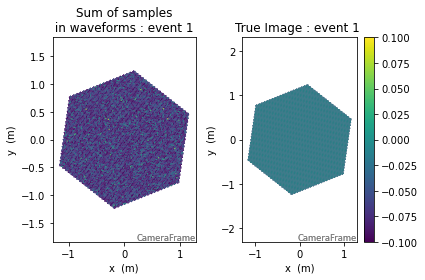

In [20]:
plot_event(1, path+file_nsb)

In [9]:
source = EventSource(path+file_no_xt, max_events=1, back_seekable=True)
seeker = EventSeeker(source)


for event in source:
    print(event)

TraitError: Path "/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_0.25/light_emission/output/NSB_5MHz_test_Gain_10_pxt_0_no_electronicnoise_10000.simtel.gz" does not exist

In [21]:
def get_charge(y, left_side, right_side, baseline):
    if (left_side < 0): 
        left_side = 0
        
    if (right_side < 0):
        right_side = -1
        left_side = -10
        
    charge = np.sum(y[left_side:right_side])
    charge -= len(y[left_side:right_side])*baseline
    
    return charge

In [22]:
def get_baseline(y, left_side, right_side):
    if (left_side < 0): 
        left_side = 0
        
    if (right_side < 0):
        right_side = -1
        left_side = -10
        
    baseline = np.mean(y[left_side:right_side])
    
    return baseline

In [23]:
def do_fast_ana(threshold, max_events, file):
    
    FWHM = 3
    
    from scipy.misc import electrocardiogram
    from scipy.signal import find_peaks

    amplitudes_map = {}
    time_map = {}
    baseline_map = {}
    charge_map = {}
    
    source = EventSource(file, max_events=max_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
    #   
        for pixel in range( len(event.r0.tel[1].waveform[0]) ):
    #    
            y = event.r0.tel[1].waveform[0][pixel][:50]
    #       
            peaks, _ = find_peaks(y, height=threshold)
            
            for i_peak in range (len(peaks)):
                try:
                    tmp_time_map = time_map[pixel]
                    tmp_time_map.append(peaks[i_peak])
                except:
                    tmp_time_map = [peaks[i_peak]]
                    
                time_map[pixel] = tmp_time_map
                
                #print(peaks, peaks[-1], peaks[0])
                
                if(i_peak == 0):
                    baseline_tmp = get_baseline(y, 0, peaks[i_peak]-FWHM)
                    
                    try:
                        tmp_baseline_map = baseline_map[pixel]
                        tmp_baseline_map.append(baseline_tmp)
                    except:
                        tmp_baseline_map = [baseline_tmp]
                    baseline_map[pixel] = tmp_baseline_map
                    
                    
                try:
                    tmp_amplitude_map = amplitudes_map[pixel]
                    tmp_amplitude_map.append( y[peaks[i_peak]] - baseline_tmp )
                except:
                    tmp_amplitude_map = [y[peaks[i_peak]] - baseline_tmp]
                amplitudes_map[pixel] = tmp_amplitude_map
                
                
                charge_tmp = get_charge(y, peaks[i_peak]-FWHM, peaks[i_peak]+FWHM, baseline_tmp)
                
                try:
                    tmp_charge_map = charge_map[pixel]
                    tmp_charge_map.append( charge_tmp )
                except:
                    tmp_charge_map = [charge_tmp]
                charge_map[pixel] = tmp_charge_map
                
                
            
    return time_map, baseline_map, amplitudes_map, charge_map

In [24]:
def do_get_max(max_events, file, left_r, right_r, integrate_l, integrate_r):
    FWHM = 3
    
    from scipy.misc import electrocardiogram
    from scipy.signal import find_peaks

    amplitudes_list = []
    time_list = []
    baseline_list = []
    charge_list = []
    
    charge_map = {}
    
    source = EventSource(file, max_events=max_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
    #   
        y = event.r0.tel[1].waveform[0]
        y_trans = np.transpose(y)
        
        time_tmp = np.argmax(y_trans[left_r:right_r], axis = 0)
        baseline_tmp = np.mean(y_trans, axis = 0)
        
        time_list.append(time_tmp)
        baseline_list.append(baseline_tmp)
        
        #print(y_trans[i] for i in time_tmp)
        #print(y_trans[i] for i in range(10))
        #print(len(time_tmp))
        #print(y_trans[time_tmp[3]])
        #print('============')
        #print(y_trans)
        #print(time_tmp[3])
        #print(time_tmp[i] for i in time_tmp)
        
        
        amplitudes_list.append( np.max(y_trans[left_r:right_r], axis = 0) - baseline_tmp)
        
        #time_tmp = np.transpose(time_tmp)
        
        #print(time_tmp)                                                                                                                                                                                                    
   
        #charge_list.append( np.sum(y_trans[integrate_l + i:integrate_r+i] for i in range(10), axis = 0) )
        #amplitudes_list.append( np.max(y_trans[left_r:right_r], axis = 0))
        
        
                
                
    return time_list, baseline_list, amplitudes_list, charge_list
    

In [34]:
time_map, baseline_map, amplitudes_map, charge_map = do_fast_ana(350, 10000, path+file_nsb)

IndexError: Out of bounds on buffer access (axis 0)

In [30]:
amplitudes_map[0]





[103.0,
 103.0,
 103.0,
 193.0,
 99.0,
 102.0,
 104.0,
 102.0,
 101.0,
 103.0,
 101.0,
 191.92857142857144,
 84.92857142857144,
 99.96153846153845,
 100.0,
 100.0,
 102.0,
 105.0,
 102.0,
 100.0,
 104.0,
 73.0,
 74.0,
 104.0,
 103.0,
 99.0,
 99.0,
 100.0,
 103.0,
 100.0,
 99.0,
 103.0,
 102.0,
 99.0,
 102.0,
 101.0,
 102.0,
 91.68181818181819,
 96.0,
 101.0,
 nan,
 102.0,
 98.0,
 100.0,
 173.0,
 102.0,
 98.0,
 101.0,
 100.0,
 95.0,
 96.0,
 101.0,
 96.0,
 183.0,
 98.0,
 109.0,
 98.0,
 97.0,
 103.0,
 102.0,
 134.0,
 103.0,
 84.875,
 103.0,
 103.0,
 102.0,
 100.0,
 103.0,
 105.0,
 99.0,
 157.0,
 102.0,
 99.0,
 102.0,
 104.0,
 98.0,
 101.0,
 101.0,
 99.0,
 89.95999999999998,
 101.0,
 102.0,
 105.0,
 101.0,
 101.0,
 186.0,
 95.0,
 103.0,
 99.0,
 103.0,
 102.0,
 104.0,
 101.0,
 100.0,
 95.0,
 100.0,
 104.0,
 100.0,
 102.0,
 101.0,
 96.0,
 97.0,
 102.0,
 104.0,
 98.0,
 96.0,
 98.0,
 131.0,
 98.0,
 102.0,
 102.0,
 101.35000000000002,
 186.0,
 nan,
 nan,
 102.0,
 87.89999999999998,
 102.0,
 98.

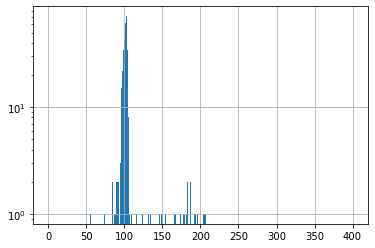

9.1  MHz


In [33]:
plt.hist(amplitudes_map[0], range = [0, 400], bins = 400)

plt.grid(True)
plt.yscale('log')
plt.show()

print(len(amplitudes_map[0])/50., " MHz" )

In [118]:
pulse_time_no_xt, baseline_no_xt, amplitude_no_xt, charge_no_xt = do_get_max(10000, path+"ff-1m_nsb_5MHz_pxt_0_no_noise_10k_events.simtel.gz", 0, 50, 3, 7)
amplitude_no_xt_corrected = np.transpose(amplitude_no_xt)

baseline_no_xt_corrected = np.transpose(baseline_no_xt)

In [1]:
import itertools

#n_events = [] 
#bins = []
#patches = []

n_events, bins, patches = plt.hist(amplitude_no_xt_corrected[0] , bins=50, range = [-10, 40])

for i_pixel in range (len(amplitude_no_xt_corrected)):
    
    n_events_tmp, bins_tmp, patches_tmp = plt.hist(amplitude_no_xt_corrected[i_pixel] , bins=50, range = [-10, 40])
    if i_pixel > 0:
        n_events = n_events + n_events_tmp
    
    #n_events.append(n_events_tmp)
    #bins.append(bins_tmp)
    #patches.append(patches_tmp)
    
#plt.hist(amplitude_no_xt_corrected[0] , bins=50, range = [-10, 40])
#plt.hist(amplitude_no_xt_corrected[1] , bins=50, range = [-10, 40])
#plt.hist(amplitude_no_xt_corrected[2] , bins=50, range = [-10, 40])
#plt.hist(amplitude_no_xt_corrected[3] , bins=50, range = [-10, 40])
#plt.hist(baseline_35_new_corrected[10], bins=76, range = [-5, 70])

plt.plot(bins[:-1], n_events, '--r', label='fit')

plt.grid(True)
plt.yscale('log')
#plt.show()

#amplitude_no_xt_corrected[0].extend(amplitude_no_xt_corrected[1])

#plt.hist([amplitude_no_xt_corrected[i] for i in range(10)] , bins=50, range = [-10, 40])
#plt.hist(all, bins=50, range = [-10, 40])
#plt.grid(True)
#plt.yscale('log')
#plt.show()

NameError: name 'plt' is not defined

In [31]:
n_random=np.random.poisson(l_mean, int(n_events))

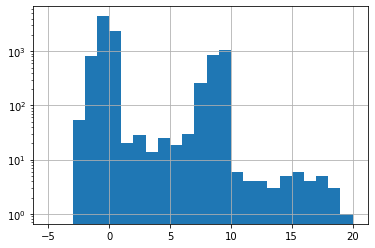

In [129]:
n_events, bins, patches = plt.hist(amplitude_no_xt_corrected[0], bins=25, range = [-5, 20])
#plt.hist(10*n_random, bins=50, range = [-10, 40])
plt.grid(True)
plt.yscale('log')
plt.show()

In [130]:
events = np.sum(n_events_tmp)
l_mean = -math.log(np.sum(n_events[:9])/np.sum(n_events))
print(events, " ", l_mean)
print(bins[:9])

10000.0   0.25838220340691886
[-5. -4. -3. -2. -1.  0.  1.  2.  3.]


In [133]:
l_mean_1 = -math.log(np.sum(n_events[9:18])/np.sum(n_events))
print(bins[9:18])
l_mean_1

[ 4.  5.  6.  7.  8.  9. 10. 11. 12.]


1.491654876777717

In [134]:
l_mean_2 = -math.log(np.sum(n_events[18:])/np.sum(n_events))
print(bins[18:])
l_mean_2

[13. 14. 15. 16. 17. 18. 19. 20.]


5.914503505971854

In [127]:
N_norm = [np.sum(n_events[:9])/np.sum(n_events), np.sum(n_events[9:18])/np.sum(n_events), np.sum(n_events[18:])/np.sum(n_events)]
N = [np.sum(n_events[:9]), np.sum(n_events[9:18]), np.sum(n_events[18:])]

x = [0.5, 1.5, 2.5]

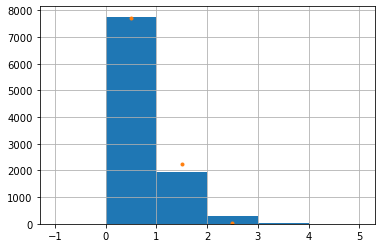

In [102]:
#plt.hist(n_random, bins=6, range = [-1, 5], density=True)
plt.hist(n_random, bins=6, range = [-1, 5])
plt.plot(x, N, '.')
plt.grid(True)
#plt.yscale('log')
plt.show()

In [128]:
print(N[1])

2250.0


In [76]:
bins[18:]

array([13., 14., 15., 16., 17., 18., 19., 20.])

In [77]:
bins[9:18]

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [52]:
all = np.array([amplitude_no_xt_corrected[0], amplitude_no_xt_corrected[1], amplitude_no_xt_corrected[2]])
#allDays.shape
#amplitude_no_xt_corrected.shape
all

array([[-0.44      ,  8.54666667, -0.85333333, ...,  8.10666667,
        -0.42666667,  8.72      ],
       [-0.89333333,  0.        , -0.44      , ...,  0.        ,
        -0.44      ,  8.22666667],
       [ 8.70666667, -1.28      , -0.86666667, ...,  9.14666667,
         0.        , -0.42666667]])

In [50]:
pulse_time_35_new, baseline_35_new, amplitude_35_new, charge_35_new = do_get_max(10000, path+file_px35_new, 0, 50, 3, 7)
amplitude_35_new_corrected = np.transpose(amplitude_35_new)
baseline_35_new_corrected = np.transpose(baseline_35_new)

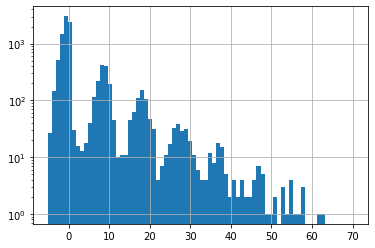

In [51]:
plt.hist(amplitude_35_new_corrected[10], bins=76, range = [-5, 70])
#plt.hist(baseline_35_new_corrected[10], bins=76, range = [-5, 70])

plt.grid(True)
plt.yscale('log')
plt.show()

In [37]:
pulse_time_no_ge, baseline_no_ge, amplitude_no_ge, charge_no_ge = do_get_max(10000, path+"NSB_5MHz_test_Gain_10_pxt_0_no_electronicnoise_10000.simtel.gz", 0, 40, 3, 7)

In [16]:
pulse_time_g14, baseline_g14, amplitude_g14, charge_g14 = do_get_max(10000, path+file_5MHz_14Gain, 0, 50, 3, 7)

In [59]:
pulse_time_g16, baseline_g16, amplitude_g16, charge_g16 = do_get_max(10000, path+"NSB_5MHz_test_Gain_16_pxt_35_10000.simtel.gz", 0, 50, 3, 7)

In [20]:
pulse_time_g11, baseline_g11, amplitude_g11, charge_g11 = do_get_max(10000, path+file_5MHz_11Gain_Pxt15, 0, 50, 3, 7)

In [71]:
pulse_time_g13, baseline_g13, amplitude_g13, charge_g13 = do_get_max(10000, path+"NSB_5MHz_test_Gain_13_pxt_15_10000.simtel.gz", 0, 50, 3, 7)

In [12]:
pulse_time_g12_p8, baseline_g12_p8, amplitude_g12_p8, charge_g12_p8 = do_get_max(10000, path+"NSB_5MHz_test_Gain_12_pxt_8_10000.simtel.gz", 0, 50, 3, 7)

In [38]:
amplitude_no_ge_corrected = np.transpose(amplitude_no_ge)

In [17]:
amplitude_g14_corrected = np.transpose(amplitude_g14)

In [60]:
amplitude_g16_corrected = np.transpose(amplitude_g16)

In [73]:
amplitude_g11_corrected = np.transpose(amplitude_g11)

In [74]:
amplitude_g13_corrected = np.transpose(amplitude_g13)

In [13]:
amplitude_g12_p8_corrected = np.transpose(amplitude_g12_p8)

/home/andrii/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


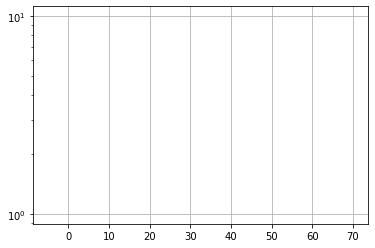

In [37]:
#plt.hist(amplitude_no_xt_corrected[10], bins=76, range = [-5, 70])
plt.hist(baseline_no_xt_corrected, bins=76, range = [-5, 70])

plt.grid(True)
plt.yscale('log')
plt.show()

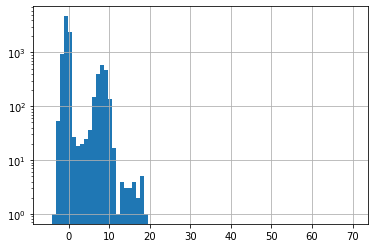

In [39]:
plt.hist(amplitude_no_ge_corrected[0], bins=76, range = [-5, 70])
#plt.hist(amplitude_g11_corrected[0], bins=76, range = [-5, 70])
plt.grid(True)
plt.yscale('log')
plt.show()

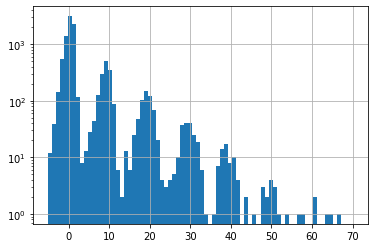

In [91]:
plt.hist(amplitude_g16_corrected[1], bins=76, range = [-5, 70])
#plt.hist(amplitude_g13_corrected[0], bins=76, range = [-5, 70])
plt.grid(True)
plt.yscale('log')
plt.show()

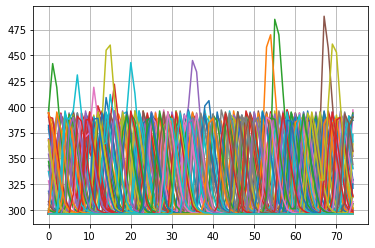

In [12]:
source = EventSource(path+file_nsb, max_events=500, back_seekable=True)
seeker = EventSeeker(source)

for event in source:
    
    x = np.arange(0, len(event.r0.tel[1].waveform[0][0]),1)
    
    #for i_pixel in range(1):
    #print(event.r0.tel[1].waveform[0][0])
        
        #print( np.allclose( event.r0.tel[1].waveform[0][i_pixel], [304]*np.ones(len(event.r0.tel[1].waveform[0][0])), rtol = 0.1 ) )
    i_pixel = 10
    plt.plot(x, event.r0.tel[1].waveform[0][i_pixel], '-')
    
plt.grid(True)
#plt.xlim(0, 50)
plt.show()

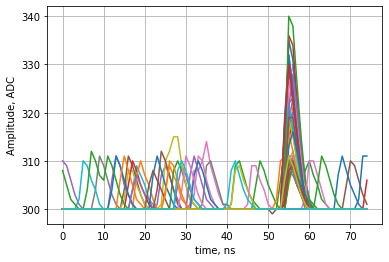

In [222]:
source = EventSource(path+"ff-1m_nsb_5MHz_pxt_0_100k_long_event.simtel.gz", max_events=100, back_seekable=True)
seeker = EventSeeker(source)

for event in source:
    
    x = np.arange(0, len(event.r0.tel[1].waveform[0][0]),1)
    
    #for i_pixel in range(1):
    #print(event.r0.tel[1].waveform[0][0])
        
        #print( np.allclose( event.r0.tel[1].waveform[0][i_pixel], [304]*np.ones(len(event.r0.tel[1].waveform[0][0])), rtol = 0.1 ) )
    i_pixel = 10
    plt.plot(x, event.r0.tel[1].waveform[0][i_pixel], '-')
    
plt.grid(True)
#plt.xlim(0, 50)
plt.grid(True)
plt.ylabel('Amplitude, ADC')
plt.xlabel('time, ns')
plt.show()

In [40]:
def calc_poisson(x, mean, xt):
    x = int(x)
    p1 = mean*math.pow(mean + xt*x, x-1)
    p2 = math.exp(-mean - xt*x)
    p3 = math.factorial(x)
    
    return p1*p2/p3

In [41]:
def gaussian(x, mu, sig):
    
    result = (np.exp( -0.5*np.power( ((x - mu)/sig), 2.) ))/(sig*np.power(2.*np.pi, 0.5) )
    
    return result

In [42]:
def spev2(x, mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt):
    #mean = 1
    #gain = 1
    #amplitude = 1
    #n_peaks = 10
    #sigma_e = 0#2.80682e-04/5.88149e-04
    #sigma_g = 0.1790991738488036#1.05337e-04/5.88149e-04
    #shift = .0
    #p_xt = 0.0
    
    #  - Gain               :  5.88149e-04 V
    #  - Sigma electronics  :  2.80682e-04 V
    #  - SiPM gain smearing :  1.05337e-04 V (in Volts)
    #  - SiPM gain smearing :  0.1790991738488036 (in units of p.e.)
    #  - Optical crosstalk  :  0.08 (agreed upon common value)
    
    f_result = 0.0
    p_xt = math.fabs(p_xt)
    
    n_peaks = np.arange(0,90,1)
    
    for i_peak in n_peaks:
            
        sigma = math.sqrt(sigma_e*sigma_e + i_peak*sigma_g*sigma_g)
        f_result = f_result + (amplitude/sigma)*( calc_poisson(i_peak, mean, p_xt) )*(gaussian(x, i_peak*gain+shift, sigma))/3.2
        #else:
        #    f_result = 0.0 
        
    return f_result

In [1]:

#plt.hist(amplitude_g11_corrected[0], bins=76, range = [-5, 70])
#plt.yscale('log')

x_adc = np.arange(-10, 80, 0.1)

mean = 0.25
gain = 10
amplitude = 13.00000000e+07
sigma_e = 6.58835545e-01
sigma_g = 1.01873898e+00
shift = -1.01873898e+00
p_xt = 0.0

mean2 = 0.1
gain2 = 8.83155702e+00
amplitude2 = 1.92940090e+04
sigma_e2 = 6.63570875e-01
sigma_g2 = 9.00000000e-01
shift2 = -8.03020664e-01
p_xt2 = 0.0

    
curve = spev2(x_adc, mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt)
curve2 = spev2(x_adc, mean2, gain2, amplitude2, sigma_e2, sigma_g2, shift2, p_xt2)

plt.plot(x_adc, curve, '--r', label='fit with mean = 0.25, Pxt = 0.')
plt.plot(x_adc, curve2, '-r', label='fit with mean = 0.10, Pxt = 0.')
#plt.plot(bins[:-1], n_events, '--r', label='Sim_telarray, 8798 pixels, only NSB, Pxt = 0.0')
plt.grid(True)
plt.xlabel('amplitude, ADC')
plt.ylim(0.1, 80000000000)
#plt.xlim(-10, 40)

#plt.hist(x=n_events, bins=bins[:-1], range = [-5, 40])

plt.bar(bins[:-1], n_events, label='Sim_telarray, 8798 pixels, only NSB, Pxt = 0.0')
plt.hist(amplitude_no_ge_corrected[0], bins=46, range = [-5, 40], color = "lime",  label='Sim_telarray, single pixel, only NSB, Pxt = 0.0')

plt.yscale('log')
plt.ylabel('n events')
plt.grid(True)
plt.legend(frameon=True)
plt.savefig('NSB_dist.png', dpi=600)
plt.show()


NameError: name 'np' is not defined

Pixel ==  0


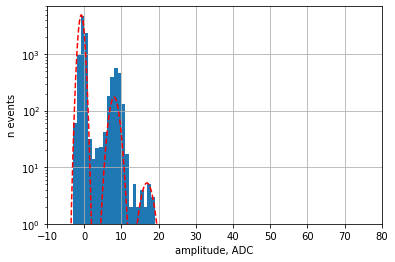

In [202]:
from scipy.optimize import curve_fit

x_adc = np.arange(-10, 80, 0.1)

mean = 0.1
mean_range = (0.0, 0.1)

gain = 10
gain_range = (6, 15.)

amplitude = 100000
amplitude_range = (-np.inf,np.inf)

sigma_e = 0.5
sigma_e_range = (0.0, 3.)

sigma_g = 1
sigma_g_range = (0.9, 3.)

shift = 0.0
shift_range= (-5., 5.)

p_xt = 0.0
p_xt_range = (0.0, 0.001)

my_par_range_min = (mean_range[0], gain_range[0], amplitude_range[0], sigma_e_range[0], sigma_g_range[0], shift_range[0], p_xt_range[0])
my_par_range_max = (mean_range[1], gain_range[1], amplitude_range[1], sigma_e_range[1], sigma_g_range[1], shift_range[1], p_xt_range[1])

my_range = (my_par_range_min, my_par_range_max)

n_pixels = 1

fit_results = []

for i_pixel in range(n_pixels):
    
    if(i_pixel%50 == 0):
        print("Pixel == ",i_pixel)
    
    n_events_tmp, bins_tmp, patches_tmp = plt.hist(amplitude_no_ge_corrected[i_pixel], bins=90, range = [-10, 80])
    
    popt_tmp, pcov_tmp = curve_fit(spev2, bins_tmp[:-1], n_events_tmp, [mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt], bounds=my_range )
    #popt_tmp, pcov_tmp = curve_fit(spev2, bins[:-1], n_events, [mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt], bounds=my_range )
    plt.plot(x_adc, spev2(x_adc, *popt_tmp), '--r', label='fit')
    fit_results.append(popt_tmp)
    
    mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt = popt_tmp
    
    
#plt.plot(bins[:-1], n_events, '--g', label='Sim_telarray, 8798 pixels, only NSB, Pxt = 0.0')
plt.grid(True)
plt.xlabel('amplitude, ADC')
plt.ylim(1, 7000)
plt.xlim(-10, 80)
plt.yscale('log')
plt.ylabel('n events')
plt.grid(True)
plt.show()

In [203]:
fit_results

[array([ 1.00000000e-01,  8.83155702e+00,  1.92940090e+04,  6.63570875e-01,
         9.00000000e-01, -8.03020664e-01,  1.03043253e-14])]

Pixel ==  0
Pxt :  0.09635879218472469
Pxt :  0.08362676056338028
Pxt :  0.08816914080071975
Pxt :  0.09813721035892777
Pxt :  0.08883025505716799
Pxt :  0.08927770300583221
Pxt :  0.10717410323709536
Pxt :  0.09954128440366973
Pxt :  0.08566355969818021
Pxt :  0.08092738407699038
Pixel ==  10
Pxt :  0.09487063095778484
Pxt :  0.09715318572074108
Pxt :  0.10684931506849316
Pxt :  0.08768084173608066
Pxt :  0.09002770083102493
Pxt :  0.09830818472793781
Pxt :  0.08340611353711791
Pxt :  0.10955816050495942
Pxt :  0.09709618874773139
Pxt :  0.09895596913300045
Pixel ==  20
Pxt :  0.08056440600819299
Pxt :  0.08613728129205922
Pxt :  0.10898576512455516
Pxt :  0.11393596986817325
Pxt :  0.08725761772853186
Pxt :  0.09427153811456923
Pxt :  0.09523809523809523
Pxt :  0.09070990359333918
Pxt :  0.09219858156028368
Pxt :  0.10213880401571367
Pixel ==  30
Pxt :  0.09187749667110519
Pxt :  0.09581395348837209
Pxt :  0.09013068949977468
Pxt :  0.09699869508481948
Pxt :  0.08238507055075102
Pxt 

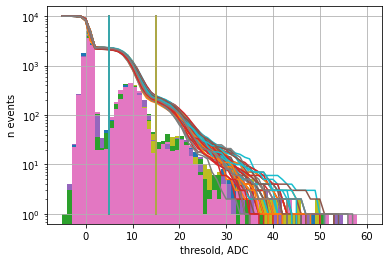

In [44]:
n_pixels = 50

amplitude = 10

y_line = [1, 10000]

for i_pixel in range(n_pixels):
    
    if(i_pixel%10 == 0):
        print("Pixel == ",i_pixel)
    
    n_events_tmp, bins_tmp, patches_tmp = plt.hist(amplitude_g12_p8_corrected[i_pixel], bins=65, range = [-5, 60])
    
    n_events_th = []

    #x_binx = np.arange(0, len(n_events_tmp), 1)
    #amplitude_index = int(amplitude/(x_binx[]))

    amplitude_index = int(amplitude/(bins_tmp[1]-bins_tmp[0]))
    
    for i_bin in range(len(n_events_tmp)):
        n_events_th.append(np.sum(n_events_tmp[i_bin:]))
        
    
    plt.plot(bins_tmp[:-1], n_events_th)
    nbin_offset = math.fabs(bins_tmp[0]/(bins_tmp[1]-bins_tmp[0]))
    
    plt.plot([ bins_tmp[int(nbin_offset + 1.5*amplitude_index)], bins_tmp[int(nbin_offset + 1.5*amplitude_index)] ], y_line)
    plt.plot([ bins_tmp[int(nbin_offset + 0.5*amplitude_index)], bins_tmp[int(nbin_offset + 0.5*amplitude_index)] ], y_line)
    print("Pxt : ", n_events_th[int(nbin_offset + 1.5*amplitude_index)]/n_events_th[int(nbin_offset + 0.5*amplitude_index)] )
    
    
plt.xlabel('thresold, ADC')
#plt.xlim(1, 50)
plt.ylabel('n events')
plt.yscale('log')
plt.grid(True)
plt.show()
    

In [80]:
x_binx[1]-x_binx[0]

1

In [73]:
fit_results=np.transpose(fit_results)

In [58]:
fit_results[1]

array([9.18158764, 8.82206044, 8.65501639, 9.51671058, 9.20369387,
       9.85296819, 9.05321278, 9.30968899, 9.41736369, 9.31075761])

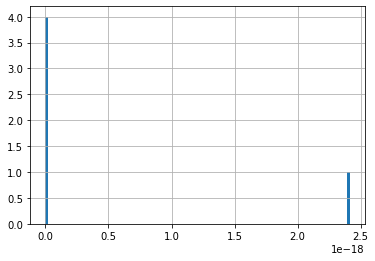

In [75]:
plt.hist(fit_results[6], bins=100)
plt.grid(True)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


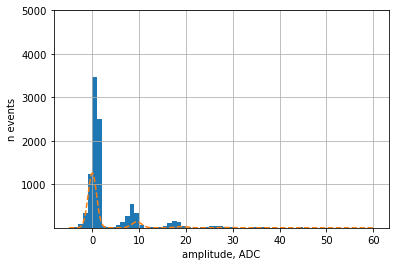

In [453]:
x_adc = np.arange(-5, 60, 0.1)

mean = 0.2
mean_range = (0.01, 10)

gain = 9.5
gain_range = (3., 15.)

amplitude = 10000
amplitude_range = (-np.inf,np.inf)

sigma_e = 0.9
sigma_e_range = (0.0, 3.)

sigma_g = 0.6
sigma_g_range = (0.0, 3.)

shift = 0.0
shift_range= (-5., 5.)

shift_0pe = 0
shift_0pe_range= (-5., 5.)

p_xt = 0.35
p_xt_range = (0.0, 0.5)

my_par_range_min = (mean_range[0], gain_range[0], amplitude_range[0], sigma_e_range[0], sigma_g_range[0], shift_0pe_range[0], shift_range[0], p_xt_range[0])
my_par_range_max = (mean_range[1], gain_range[1], amplitude_range[1], sigma_e_range[1], sigma_g_range[1], shift_0pe_range[1], shift_range[1], p_xt_range[1])
#bounds=((-np.inf,np.inf), (-np.inf,np.inf), (0,1), (0,1)

my_range = (my_par_range_min, my_par_range_max)

#y_spe = spev2(x_adc, mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt)
y_spe = spev2(x_adc, mean, gain, amplitude, sigma_e, sigma_g, shift_0pe, shift, 0.25)


n_events, bins, patches = plt.hist(amplitude_corrected[0], bins=65, range = [-5, 60])
plt.grid(True)
#plt.show()

plt.plot(x_adc, y_spe, '--')
plt.xlabel('amplitude, ADC')
plt.ylim(0.01, 5000)
plt.ylabel('n events')
#plt.yscale('log')
plt.grid(True)
plt.show()

In [330]:
def calc_derivative(y):
    
    return np.gradient(y)

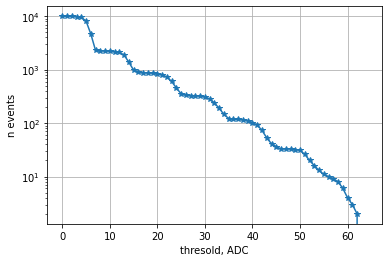

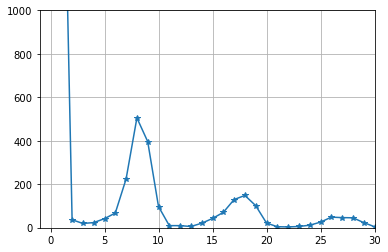

9498.0   2108.0
0.3894404332129964


In [437]:
from numpy import diff

n_events_th = []

x_binx = np.arange(0, len(n_events), 1)

for i_bin in range(len(n_events)):
    n_events_th.append(np.sum(n_events[i_bin:]))
    
d_n_events_th = diff(n_events_th)

plt.plot(x_binx, n_events_th, '*-')
plt.xlabel('thresold, ADC')
#plt.xlim(1, 50)
plt.ylabel('n events')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.plot(bins[:-2], -d_n_events_th, '-*')
plt.grid(True)
plt.ylim(-1, 1000)
plt.xlim(-1, 30)
plt.show()

print(n_events_th[4], ' ', n_events_th[12])
print(n_events_th[19]/n_events_th[10])

In [ ]:

for i_pixel in range 10:
    n_events, bins, patches = plt.hist(amplitude_corrected[i_pixel], bins=60, range = [0, 60])
    
    

In [338]:
len(bins)

61

In [454]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(spev2, bins[:-1], n_events, [mean, gain, amplitude, sigma_e, sigma_g, shift_0pe, shift, p_xt], bounds=my_range )

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 5

 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


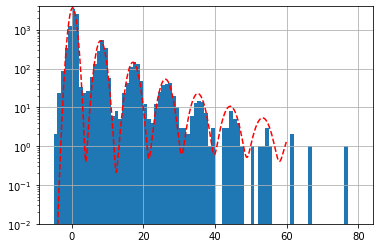

In [455]:
#plt.hist(ampli[0], bins=70)
plt.hist(amplitude_corrected[0], bins=85, range = [-5, 80])

plt.plot(x_adc, spev2(x_adc, *popt), '--r', label='fit')
plt.grid(True)

plt.yscale('log')
plt.ylim(0.01, 4000)
plt.show()

In [456]:
popt

array([ 3.48945283e-01,  9.04891071e+00,  2.82287483e+04,  8.20667279e-01,
        6.58418236e-01,  2.29892572e-01, -1.01591029e+00,  4.04958649e-01])

In [27]:
x = np.arange(40)

index_max = []
amplitude_max_test = []
waveform_shift = np.array(len(x)-3)

for event_id in range( len(baseline_map[0][:2]) ):
    index_max.append(np.argmax(waveform_map[10][event_id]))
    amplitude_max_test.append(waveform_map[10][event_id][26] - np.mean(waveform_map[10][event_id][:20]))
    
    for i_point in range(len(waveform_map[10][event_id])-3):
        
        waveform_shift[i_point] = waveform_map[10][event_id][i_point] - waveform_map[10][event_id][i_point+2]
    
        #plt.plot(x[:len(waveform_shift)], waveform_shift)
    
plt.grid(True)
plt.xlabel('time, ns')
plt.ylabel('ADC')
plt.show()

/home/andrii/anaconda3/envs/cta/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ushort_scalars
  del sys.path[0]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed